<a href="https://colab.research.google.com/github/OleksiiLatypov/llm-zoomcamp/blob/main/hw_ml_zoomcamp/hw04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

In [2]:
!wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
!unzip bank+marketing.zip
!unzip bank.zip

--2024-10-21 17:39:22--  https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank+marketing.zip’

bank+marketing.zip      [  <=>               ] 999.85K  2.44MB/s    in 0.4s    

2024-10-21 17:39:23 (2.44 MB/s) - ‘bank+marketing.zip’ saved [1023843]

Archive:  bank+marketing.zip
 extracting: bank.zip                
 extracting: bank-additional.zip     
Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                


In [3]:
df = pd.read_csv('/content/bank-full.csv', sep=';')
df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


In [4]:
df.y.value_counts()

,count
y,
no,39922
yes,5289


In [5]:
columns = [
    'age', 'job', 'marital', 'education', 'balance', 'housing',
    'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
    'previous', 'poutcome', 'y'
]
df = df[columns]

In [6]:
df.shape

(45211, 15)

In [7]:
df.head(3)

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no


In [ ]:
# binary_labels = {'no': 0, 'yes': 1}

#df['y'] = df['y'].map(binary_labels)

In [8]:
df.y = (df.y == 'yes').astype(int)

In [9]:
df.y.value_counts()

,count
y,
0,39922
1,5289


In [10]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

In [11]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(27126, 14)
(9042, 14)
(9043, 14)


In [12]:
df_train.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome
0,56,entrepreneur,married,tertiary,40,no,cellular,11,jul,123,2,-1,0,unknown
1,33,technician,married,secondary,4790,yes,cellular,20,apr,137,1,272,2,failure
2,32,technician,single,tertiary,392,yes,cellular,21,nov,148,2,-1,0,unknown
3,40,admin.,divorced,secondary,2129,no,cellular,30,apr,452,1,-1,0,unknown
4,54,unemployed,married,tertiary,1180,no,cellular,19,nov,394,2,-1,0,unknown


**Question 1: ROC AUC feature importance**

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score and compute AUC with the y variable
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?


* balance
* day
* duration
* previous


In [13]:
numerical_data = df_train.select_dtypes(include=['number']).columns.tolist()
numerical_data

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [14]:
categorical_data = df_train.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_data

['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

In [15]:
numerical_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

categorical_columns = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']

In [16]:
df['y'].value_counts()

,count
y,
0,39922
1,5289


In [17]:
def find_roc_auc_score(columns: List[int]) -> Tuple[dict, str]:
  auc_scores = {}
  for col in numerical_columns:
    auc = roc_auc_score(df['y'], df[col])
    # If AUC < 0.5, invert the variable
    if auc < 0.5:
        auc = roc_auc_score(df['y'], -df[col])
    auc_scores[col] = auc
  # Find the numerical variable with the highest AUC
  best_feature = max(auc_scores, key=auc_scores.get)
  return auc_scores, best_feature

In [18]:
auc_scores, best_feature = find_roc_auc_score(numerical_columns)
# Output the AUC scores and the best feature
print("AUC Scores:", auc_scores)
print("Best numerical feature by AUC:", best_feature)

AUC Scores: {'age': 0.5078552662471552, 'balance': 0.590061489160812, 'day': 0.5265199356555834, 'duration': 0.8075955951124923, 'campaign': 0.5723342144142696, 'pdays': 0.593224032562116, 'previous': 0.6023034054239005}
Best numerical feature by AUC: duration


**Question 2:**

Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

*LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)*

In [19]:
columns = numerical_columns + categorical_columns
train_dicts = df_train[columns].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

val_dicts = df_val[columns].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:, 1]

In [20]:
roc_auc_score(y_val, y_pred)

0.9004159581551736

In [21]:
# Assuming you've already split your data and have y_val
y_scores = model.predict_proba(X_val)[:, 1]  # Probability of the positive class

# Calculate the ROC curve using the validation set
fpr, tpr, thresholds = roc_curve(y_val, y_scores)

# Calculate the AUC
roc_auc = auc(fpr, tpr)

# Output the AUC score
print("AUC:", roc_auc)


AUC: 0.9004159581551736


In [22]:
y_pred_bin = model.predict(X_val)

**Question 3:**

 Precision and Recall

In [23]:
fpr[:10]

array([0.        , 0.00012588, 0.00050352, 0.00050352, 0.00062941,
       0.00062941, 0.00075529, 0.00075529, 0.00100705, 0.00100705])

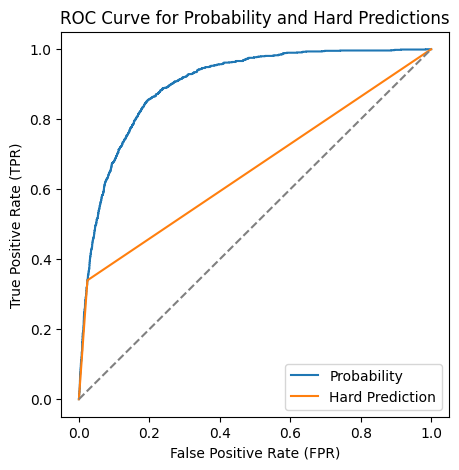

In [24]:
plt.figure(figsize=(5, 5))

# ROC curve for predicted probabilities
fpr, tpr, _ = roc_curve(y_val, y_pred)
plt.plot(fpr, tpr, label='Probability')

# ROC curve for binary (hard) predictions
fpr, tpr, _ = roc_curve(y_val, y_pred_bin)
plt.plot(fpr, tpr, label='Hard Prediction')

# Diagonal line representing random guessing
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

# Set the title and axis labels
plt.title('ROC Curve for Probability and Hard Predictions')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')

# Add legend and show the plot
plt.legend()
plt.show()


[ 0.         -0.00012588 -0.00050352  0.0058717   0.00574582  0.00938881
  0.00926293  0.01290592  0.01265415  0.01447565]
1001
0.6596090667459098


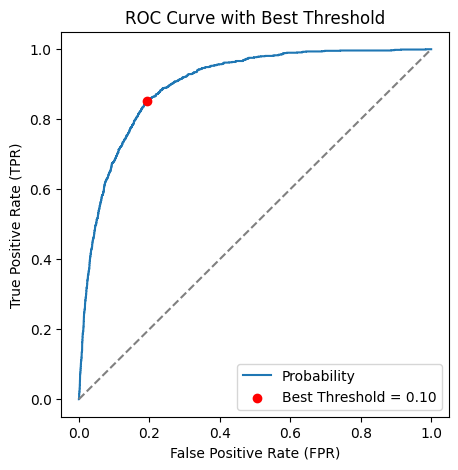

The best threshold is: 0.10


In [47]:
from sklearn.metrics import roc_curve

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

# Calculate Youden's J statistic for each threshold
youden_j = tpr - fpr
print(youden_j[:10])

idx = 0
max_value = 0

for i in range(len(youden_j)):
  if youden_j[i] > max_value:
    max_value = youden_j[i]
    idx = i
print(idx)
print(max_value)

# Find the index of the maximum Youden's J statistic
best_index = youden_j.argmax()
#print(best_index)
# Find the best threshold
best_threshold = thresholds[best_index]
#print(best_threshold)
# Plot the ROC curve
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Probability')

# Diagonal line representing random guessing
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')

# Highlight the best threshold point
plt.scatter(fpr[best_index], tpr[best_index], color='red', label=f'Best Threshold = {best_threshold:.2f}', zorder=10)

# Set the title and axis labels
plt.title('ROC Curve with Best Threshold')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')

# Add legend and show the plot
plt.legend()
plt.show()

print(f'The best threshold is: {best_threshold:.2f}')


In [25]:
print(y_val[:15])
print(y_pred[:15].round(3))

[0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
[0.03  0.023 0.021 0.015 0.027 0.039 0.054 0.033 0.061 0.007 0.68  0.042
 0.007 0.012 0.038]


In [48]:
def confusion_matrix_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    return df_scores


df_scores = confusion_matrix_dataframe(y_val, y_pred)
df_scores[::10]

,threshold,tp,fp,fn,tn
0,0.0,1098,7944,0,0
10,0.1,926,1493,172,6451
20,0.2,712,693,386,7251
30,0.3,566,407,532,7537
40,0.4,462,272,636,7672
50,0.5,373,192,725,7752
60,0.6,290,137,808,7807
70,0.7,225,101,873,7843
80,0.8,148,67,950,7877
90,0.9,76,27,1022,7917


In [49]:
df_scores['p'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['r'] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [50]:
df_scores[::10]

,threshold,tp,fp,fn,tn,p,r
0,0.0,1098,7944,0,0,0.121433,1.000000
10,0.1,926,1493,172,6451,0.382803,0.843352
20,0.2,712,693,386,7251,0.506762,0.648452
30,0.3,566,407,532,7537,0.581706,0.515483
40,0.4,462,272,636,7672,0.629428,0.420765
50,0.5,373,192,725,7752,0.660177,0.339709
60,0.6,290,137,808,7807,0.679157,0.264117
70,0.7,225,101,873,7843,0.690184,0.204918
80,0.8,148,67,950,7877,0.688372,0.134791
90,0.9,76,27,1022,7917,0.737864,0.069217


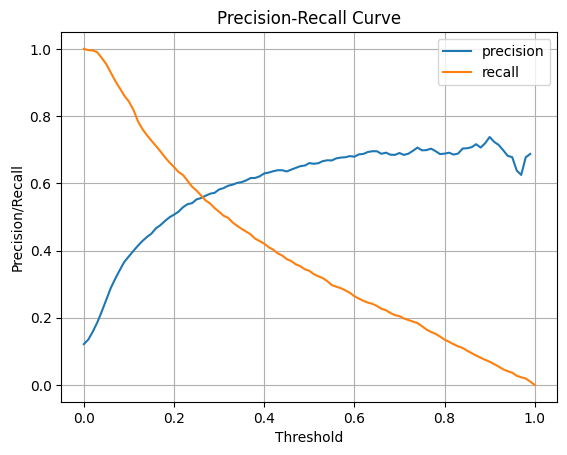

In [51]:
import matplotlib.pyplot as plt

plt.plot(df_scores.threshold, df_scores.p, label='precision')
plt.plot(df_scores.threshold, df_scores.r, label='recall')

# Set x and y labels
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')

plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
df_scores[df_scores['p'].round(1) == df_scores['r'].round(1)]

,threshold,tp,fp,fn,tn,p,r
25,0.25,635,515,463,7429,0.552174,0.578324
26,0.26,619,494,479,7450,0.556155,0.563752


**Question 4:**

F1 score
Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F
1
=
2
⋅
P
⋅
R
P
+
R

Where
P
 is precision and
R
 is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

0.02
0.22
0.42
0.62

In [53]:
df_scores['f1'] = 2 * (df_scores['p'] * df_scores['r']) / (df_scores['p'] + df_scores['r'])

In [54]:
df_scores[::10]

,threshold,tp,fp,fn,tn,p,r,f1
0,0.0,1098,7944,0,0,0.121433,1.000000,0.216568
10,0.1,926,1493,172,6451,0.382803,0.843352,0.526585
20,0.2,712,693,386,7251,0.506762,0.648452,0.568917
30,0.3,566,407,532,7537,0.581706,0.515483,0.546596
40,0.4,462,272,636,7672,0.629428,0.420765,0.504367
50,0.5,373,192,725,7752,0.660177,0.339709,0.448587
60,0.6,290,137,808,7807,0.679157,0.264117,0.380328
70,0.7,225,101,873,7843,0.690184,0.204918,0.316011
80,0.8,148,67,950,7877,0.688372,0.134791,0.225438
90,0.9,76,27,1022,7917,0.737864,0.069217,0.126561


In [58]:
best_f1 = df_scores[df_scores['f1'] == df_scores['f1'].max()]
best_f1

,threshold,tp,fp,fn,tn,p,r,f1
22,0.22,686,611,412,7333,0.528913,0.624772,0.57286


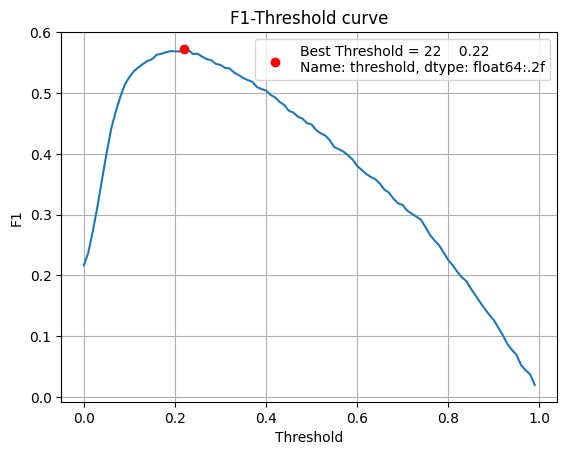

In [64]:
plt.plot(df_scores['threshold'], df_scores['f1'])
plt.scatter(best_f1['threshold'], best_f1['f1'], color='red', label=f"Best Threshold = {best_f1['threshold']}:.2f", zorder=10)

plt.xlabel('Threshold')

plt.ylabel('F1')
plt.title('F1-Threshold curve')
plt.legend()
plt.grid()
plt.show()

**Question 5:**

*5-Fold CV*

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

*KFold(n_splits=5, shuffle=True, random_state=1)*
Iterate over different folds of df_full_train
Split the data into train and validation
Train the model on train with these parameters: *LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)*
Use AUC to evaluate the model on validation
How large is standard deviation of the scores across different folds?

0.0001
0.006
0.06
0.26

In [66]:
def train_model(df_train, y_train, C=1.0):
  dicts = df_train[columns].to_dict(orient='records')
  dv = DictVectorizer(sparse=False)

  X_train = dv.fit_transform(dicts)
  model = LogisticRegression(solver='liblinear', C=C)
  model.fit(X_train, y_train)
  return dv, model

def predict(df, dv, model):
  dicts = df[columns].to_dict(orient='records')
  X_val = dv.transform(dicts)
  y_pred = model.predict_proba(X_val)[:, 1]
  return y_pred

In [69]:
def cross_validation(df_full_train):

  auc_scores = []

  kfold = KFold(n_splits=5, shuffle=True, random_state=1)

  for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.y
    y_val = df_val.y

    dv, model = train_model(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    auc_scores.append(auc)
  return auc_scores


In [78]:
result = cross_validation(df_full_train)
print(f'Mean AUC score: {np.mean(result)}')
print(f'STD: +- {np.std(result).round(3)}')

Mean AUC score: 0.9058645558975871
STD: +- 0.006


**Question 6:**

Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.000001, 0.001, 1]
Initialize KFold with the same parameters as previously
Use these parameters for the model: *LogisticRegression(solver='liblinear', C=C, max_iter=1000)*
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)
Which C leads to the best mean score?

0.000001
0.001
1

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [106]:
def find_best_c(df_full_train: pd.DataFrame) -> List[float]:
  kfold = KFold(n_splits=5, shuffle=True, random_state=1)
  results = {}
  mean_results = {}
  std_results = {}
  for C in [0.000001, 0.001, 1]:
      auc_scores = []
      for train_idx, val_idx in kfold.split(df_full_train):
          df_train = df_full_train.iloc[train_idx]
          df_val = df_full_train.iloc[val_idx]

          y_train = df_train['y']
          y_val = df_val['y']

          dv, model = train_model(df_train, y_train, C=C)
          y_pred = predict(df_val, dv, model)

          auc = roc_auc_score(y_val, y_pred)
          auc_scores.append(auc.round(3))
      results[f'C_{C}'] = auc_scores
      mean_results[f'C_{C}'] = np.mean(auc_scores).round(3)
      std_results[f'C_{C}'] = np.std(auc_scores).round(3)
  return results, mean_results, std_results

In [107]:
result, mean_auc, std_auc_scores = find_best_c(df_full_train)
print(result)
#mean_c_list = {k: np.mean(v) for k, v in c_list.items()}
print(mean_auc)
print(std_auc_scores)


{'C_1e-06': [0.685, 0.7, 0.712, 0.709, 0.702], 'C_0.001': [0.848, 0.86, 0.864, 0.869, 0.863], 'C_1': [0.899, 0.899, 0.911, 0.908, 0.912]}
{'C_1e-06': 0.702, 'C_0.001': 0.861, 'C_1': 0.906}
{'C_1e-06': 0.009, 'C_0.001': 0.007, 'C_1': 0.006}


In [115]:

# Create a DataFrame for fold-wise AUC scores
df_auc = pd.DataFrame(result)

# Alternatively, you can directly assign mean and std values from the dictionaries
df_auc.loc['Mean'] = mean_auc
df_auc.loc['Std'] = std_auc_scores

df_auc


,C_1e-06,C_0.001,C_1
0,0.685,0.848,0.899
1,0.700,0.860,0.899
2,0.712,0.864,0.911
3,0.709,0.869,0.908
4,0.702,0.863,0.912
Mean,0.702,0.861,0.906
Std,0.009,0.007,0.006
